In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process.kernels import Kernel, StationaryKernelMixin, NormalizedKernelMixin, Matern, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV

from scipy.spatial.distance import pdist, cdist, squareform
from scipy.optimize import minimize
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [2]:
gradient_colours = ['#0000ff', '#1700ff', '#2d00ff', '#4400ff', 
                    '#5b00ff', '#7100ff', '#8800ff', '#9f00ff', 
                    '#b500ff', '#cc00ff']

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colours)

my_custom_style = {
    'figure.figsize': (8, 5),
    'figure.facecolor': 'White',
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'legend.fontsize': 'small',
    'legend.frameon': True,  
    'legend.edgecolor': 'none',  
    'legend.facecolor': 'White',
    'legend.framealpha': 1,  
    'lines.linewidth': 1.25,
    'axes.grid': False,
    'axes.linewidth': 1,
    'axes.spines.top': False,
    'axes.spines.right': False,
}

plt.rcParams.update(my_custom_style)

In [3]:
# Initialise dictionaries to store inputs and outputs for each function
inputs = {}
outputs = {}

for x in range(1, 9):
    input_path = f'initial_data/function_{x}/initial_inputs.npy'
    output_path = f'initial_data/function_{x}/initial_outputs.npy'

    # Load the numpy arrays and store them in the dictionaries
    try:
        inputs[f'input_{x}'] = np.load(input_path)
        outputs[f'output_{x}'] = np.load(output_path)
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        continue

In [4]:
outputs['output_1'].shape

(10,)

In [5]:
inputs['input_1'].shape

(10, 2)

In [6]:
def update_data(inputs, outputs, new_X, new_y):
    """
    Update the input and output dictionaries with new data.
    
    Parameters:
    - inputs: Dictionary containing the original input data.
    - outputs: Dictionary containing the original output data.
    - new_X: List of new input data arrays.
    - new_y: List of new output data values.
    """
    # Ensure that the length of new_X and new_y match the number of functions
    if not (len(new_X) == len(new_y) == len(inputs) == len(outputs)):
        raise ValueError("Length of new data does not match the number of functions")

    for x in range(1, len(new_X) + 1):
        # Update the inputs and outputs dictionaries
        inputs[f'input_{x}'] = np.vstack((inputs[f'input_{x}'], new_X[x-1]))
        outputs[f'output_{x}'] = np.append(outputs[f'output_{x}'], new_y[x-1])

In [7]:
new_X1 = [np.array([0.540885, 0.200459]), 
          np.array([0.660515, 0.867065]), 
          np.array([0.228941, 0.219917, 0.990882]), 
          np.array([0.985622, 0.00625 , 0.042186, 0.200325]), 
          np.array([0.836478, 0.358648, 0.088947, 0.07288 ]), 
          np.array([0.694682, 0.114404, 0.978806, 0.045613, 0.004911]), 
          np.array([0.057896, 0.011813, 0.125431, 0.073659, 0.112073, 0.951014]), 
          np.array([0.009077, 0.232624, 0.022929, 0.009043, 0.986902, 0.022113, 0.035909, 0.561114])]

new_X2 = [np.array([0.468719, 0.519414]), 
          np.array([0.303584, 0.88278 ]), 
          np.array([0.754098, 0.300471, 0.405299]), 
          np.array([0.96726 , 0.00625 , 0.939178, 0.358555]), 
          np.array([0.285311, 0.238917, 0.333071, 0.957591]), 
          np.array([0.021735, 0.586909, 0.016523, 0.961656, 0.310987]), 
          np.array([0.867543, 0.82196 , 0.389353, 0.239507, 0.148462, 0.068343]), 
          np.array([0.307535, 0.003419, 0.022929, 0.902986, 0.648674, 0.243092, 0.095359, 0.041956])]

new_X3 = [np.array([0.243096, 0.136037]), 
          np.array([0.243871, 0.776277]), 
          np.array([0.828329, 0.330116, 0.445234]), 
          np.array([0.96705 , 0.00625 , 0.939178, 0.358573]), 
          np.array([0.285327, 0.238928, 0.333088, 0.957644]), 
          np.array([0.021735, 0.586912, 0.016523, 0.961656, 0.310987]), 
          np.array([0.088188, 0.442152, 0.476236, 0.845859, 0.04593 , 0.088882]), 
          np.array([0.307538, 0.003419, 0.022929, 0.902986, 0.64868 , 0.243097, 0.095365, 0.041956])]

new_X4 = [np.array([0.198371, 0.259575]), 
          np.array([0.585134, 0.744414]), 
          np.array([0.046809, 0.94136 , 0.066089]), 
          np.array([0.984525, 0.508642, 0.078793, 0.235599]), 
          np.array([0.222356, 0.167773, 0.184929, 0.367689]), 
          np.array([0.021735, 0.931871, 0.016523, 0.533372, 0.004911]), 
          np.array([0.718965, 0.4301  , 0.211279, 0.11638 , 0.942807, 0.07158 ]), 
          np.array([0.366509, 0.003419, 0.998885, 0.009043, 0.009649, 0.022113, 0.035909, 0.105998])]

new_X5 = [np.array([0.675389, 0.086522]), 
          np.array([0.717223, 0.860985]), 
          np.array([0.418167, 0.433566, 0.913232]), 
          np.array([0.234388, 0.310878, 0.433911, 0.697251]), 
          np.array([0.356202, 0.195199, 0.352173, 0.534422]), 
          np.array([0.021735, 0.114404, 0.016523, 0.045613, 0.892819]), 
          np.array([0.057896, 0.479549, 0.411564, 0.073659, 0.341929, 0.951014]), 
          np.array([0.009077, 0.97398 , 0.187284, 0.009043, 0.009649, 0.022113, 0.035909, 0.930643])]

new_X6 = [np.array([0.351475, 0.138074]), 
          np.array([0.441292, 0.894201]), 
          np.array([0.965995, 0.219917, 0.066089]), 
          np.array([0.408179, 0.345841, 0.284235, 0.855754]), 
          np.array([0.143546, 0.475381, 0.836342, 0.399361]), 
          np.array([0.021735, 0.914859, 0.016523, 0.802988, 0.475745]), 
          np.array([0.145738, 0.209686, 0.124566, 0.245163, 0.315533, 0.598503]), 
          np.array([0.009077, 0.225729, 0.022929, 0.327862, 0.986902, 0.476624, 0.433935, 0.484594])]

new_X7 = [np.array([0.70089 , 0.449734]), 
          np.array([0.200446, 0.844906]), 
          np.array([0.058061, 0.219917, 0.990882]), 
          np.array([0.037825, 0.00625 , 0.042186, 0.999483]), 
          np.array([0.624979, 0.038193, 0.322789, 0.957644]), 
          np.array([0.95774 , 0.295097, 0.940942, 0.261364, 0.004911]), 
          np.array([0.50213 , 0.018908, 0.28071 , 0.863053, 0.160624, 0.565691]), 
          np.array([0.868018, 0.003419, 0.374971, 0.902986, 0.009649, 0.022113, 0.279101, 0.041956])]

In [8]:
new_y1 = [-7.621322279312054e-46, 0.3589045225376055, 
          -0.42456565894988735, -27.56119388172463, 
          1.0291446362294363, -1.690657072691126, 
          0.41573374206750857, 9.6225327295614]

new_y2 = [1.352831729102403e-09, 0.05919481220240015, 
          -0.021101253176283308, -31.52260592809994, 
          106.33646558867544, -1.7201805579210119, 
          0.03269727311028263, 9.1604996567124]

new_y3 = [5.193245132612275e-80, -0.012591175623733238, 
          -0.009259163037391946, -31.51660617085607, 
          106.43940043678197, -1.632572011896414, 
          0.0613977517875156, 9.1605031545794]

new_y4 = [-1.3857192597271433e-53, -0.03829776360780328, 
          -0.04967414463508161, -21.175984549435466, 
          144.5280127885543, -1.8888085968635349, 
          0.013209781584801185, 6.9327487642211]

new_y5 = [-8.7434279946626e-124, 0.5763544346207525, 
          -0.09645106844438231, -7.645925165658401, 
          88.52750463704984, -2.799489465121917, 
          0.7370863824271188, 8.669322201648601]

new_y6 = [-1.949986775859265e-60, 0.10889708404994333, 
          -0.06434649047912662, -12.408872841484435, 
          6.986861207299443, -1.9611272050556314, 
          2.5216560814073734, 9.7829080074224]

new_y7 = [-1.7542400781651977e-26, 0.1256192372974529, 
          -0.4386005350169414, -31.279055740165486, 
          200.0712636513843,  -1.507917962299651, 
          0.05673564909417802, 7.4674318417069]

In [9]:
update_data(inputs, outputs, new_X1, new_y1)

In [10]:
update_data(inputs, outputs, new_X2, new_y2)

In [11]:
update_data(inputs, outputs, new_X3, new_y3)

In [12]:
update_data(inputs, outputs, new_X4, new_y4)

In [13]:
update_data(inputs, outputs, new_X5, new_y5)

In [14]:
update_data(inputs, outputs, new_X6, new_y6)

In [15]:
update_data(inputs, outputs, new_X7, new_y7)

***

In [16]:
# Select a function for training

X_train =   inputs['input_1']
y_train = outputs['output_1']

In [17]:
X_train.shape

(17, 2)

In [18]:
y_train.shape

(17,)

In [19]:
class CosineSimilarityKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self, length_scale=0.1, scale=1.0):
        self.length_scale = length_scale
        self.scale = scale

    def _normalize(self, X):
        """ Normalize the rows of X to unit length. """
        return X #np.linalg.norm(X, axis=1, keepdims=True)

    def __call__(self, X, Y=None, eval_gradient=False):
        """ Calculate the kernel matrix between X and Y. """
        if eval_gradient:
            raise ValueError("Gradient evaluation not supported.")

        # Normalize X and Y
        X_normalized = self._normalize(X)
        Y_normalized = self._normalize(Y) if Y is not None else X_normalized


        # Calculate the cosine distance between each pair of points
        dists = pdist(X_normalized / self.length_scale, metric='cosine')
        K = self.scale * np.exp(-squareform(dists))
        
        # For the case where Y is not None, we need to compute the cross distance matrix.
        if Y is not None:
            cross_dists = cdist(X_normalized / self.length_scale, Y_normalized / self.length_scale, metric='cosine')
            K = self.scale * np.exp(-cross_dists)        
        return K

    def diag(self, X):
        """ Return the diagonal of the kernel k(X, X). """
        # The diagonal is scaled as well.
        return np.full(X.shape[0], self.scale, dtype=np.float64)  

    def is_stationary(self):
        """ Return True if the kernel is stationary. """
        return True


In [20]:
# Define a set of length scales and scales to search over
length_scale_options = np.logspace(-1, 10, 10)  # e.g., from 0.01 to 10

# Define a custom scorer that returns the log-marginal-likelihood
def lml_scorer(gpr, X, y):
    return gpr.log_marginal_likelihood_value_

# Set up the grid search
param_grid = {
    'kernel__length_scale': length_scale_options,
}
gpr = GaussianProcessRegressor(kernel=CosineSimilarityKernel())
grid_search = GridSearchCV(gpr, param_grid, scoring=lml_scorer)

# Fit the models and find the best combination
grid_search.fit(X_train, y_train)

# The best hyperparameters are:
best_length_scale = grid_search.best_params_['kernel__length_scale']

In [21]:
feature_count = X_train.shape[1]

if feature_count ==2:
    print('2')
elif feature_count == 1:
    print('1')
else: 
    print('3+')

2


In [22]:
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=CosineSimilarityKernel(
    length_scale=best_length_scale))

# Fit the Gaussian Process model
gp.fit(X_train, y_train)

if feature_count == 2:
# # Use the GP model to make predictions on a grid
    X_min, X_max = X_train[:, 0].min(), X_train[:, 0].max()
    Y_min, Y_max = X_train[:, 1].min(), X_train[:, 1].max()
    x = np.linspace(X_min, X_max, 100)
    y = np.linspace(Y_min, Y_max, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    XY = np.vstack((X_flat, Y_flat)).T
    # Make the prediction on the mesh
    y_pred, sigma = gp.predict(XY, return_std=True)
else:
    y_pred, sigma = gp.predict(X_train, return_std=True)


In [23]:
def gp_plot(X, Y, y_pred, X_train, y_train):
    # Create a 2x3 subplot
    fig = plt.figure(figsize=(21, 14))
    # 3D plots from different angles
    angles = [(45, 45), (45, 135), (45, 225), (0, 45), (0, 90), (0, 0)]
    for i, angle in enumerate(angles):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')

        # Plot the surface
        surf = ax.plot_surface(X, Y, y_pred.reshape(X.shape), cmap=custom_cmap, alpha=0.5)
        # Plot the training points
        if X_train is not None:
            ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='white', edgecolors='red', marker='o')

        # Set the view angle
        ax.view_init(elev=angle[0], azim=angle[1])

    plt.show()

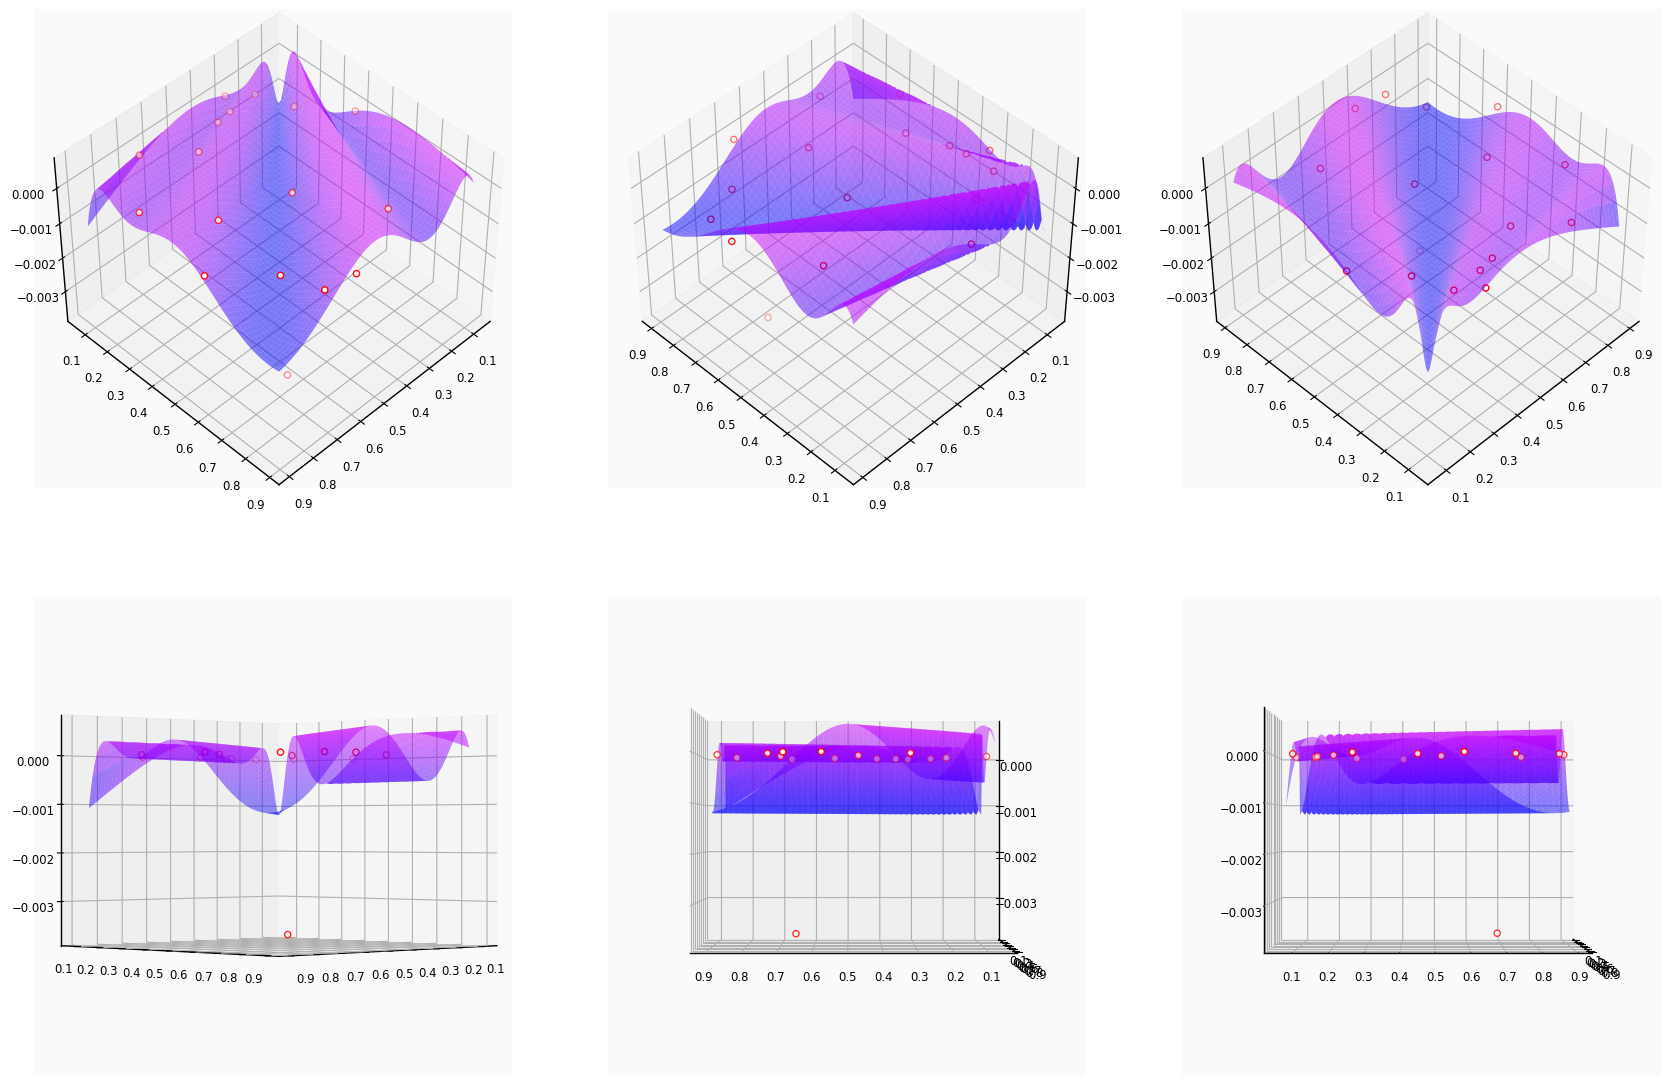

In [24]:
if feature_count == 2:
    gp_plot(X, Y, y_pred, X_train, y_train)
else:
    None

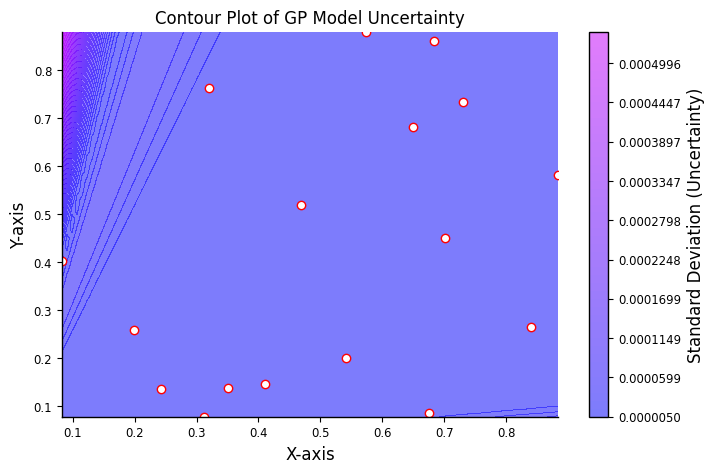

In [25]:
if feature_count == 2:
    # Define the grid over which we will calculate the predictions and uncertainties
    X_min, X_max = X_train[:, 0].min(), X_train[:, 0].max()
    Y_min, Y_max = X_train[:, 1].min(), X_train[:, 1].max()
    x = np.linspace(X_min, X_max, 100)
    y = np.linspace(Y_min, Y_max, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    XY = np.vstack((X_flat, Y_flat)).T

    # Make the prediction on the grid
    y_pred, sigma = gp.predict(XY, return_std=True)

    # Plotting the uncertainty as a contour plot
    plt.figure()
    contour_levels = np.linspace(sigma.min(), sigma.max(), 50)  # Levels for the contour lines
    contour_plot = plt.contourf(X, Y, sigma.reshape(X.shape), levels=contour_levels, cmap=custom_cmap, alpha=0.5)
    plt.colorbar(contour_plot, label='Standard Deviation (Uncertainty)')
    plt.scatter(X_train[:, 0], X_train[:, 1],  color='white', edgecolors='red', marker='o', label='Training points')
    plt.title('Contour Plot of GP Model Uncertainty')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
else:
    None

In [26]:
# Define the acquisition function
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    ''' Computes the EI at points X based on existing samples X_sample
        and Y_sample using a Gaussian process surrogate model gpr. '''
    
    # Determine the number of features from X
    n_features = X.shape[1]

    X = X.reshape(-1, n_features)
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)

    with np.errstate(divide='ignore'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [27]:
# Specify the bounds of the search space
X_bound_min = np.min(X_train, axis=0)
X_bound_max = np.max(X_train, axis=0)
bounds = [(X_bound_min[i], X_bound_max[i]) for i in range(X_train.shape[1])]

In [28]:
# Adjust the propose_location function to flatten the starting_point before passing to minimize
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    ''' Proposes the next sampling point by optimizing the acquisition function. '''
    best_value = 1
    best_x = None
    
    # Determine the number of features from X_sample
    n_features = X_sample.shape[1]

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, n_features), X_sample, Y_sample, gpr)

    # Adjust the bounds for each dimension
    adjusted_bounds = bounds  # Now, bounds should be a list of tuples

    # Finding the best optimum by starting from n_restart different random points.
    for starting_point in np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(n_restarts, n_features)):
        res = minimize(min_obj, starting_point, bounds=adjusted_bounds, method='L-BFGS-B')
        if res.fun < best_value:
            best_value = res.fun
            best_x = res.x           
    
    return best_x

# Propose location for the next sample
next_sample = propose_location(expected_improvement, X_train, y_train, gp, bounds)

# # Reshape for output
next_sample_reshaped = next_sample.reshape(-1, feature_count)
np.round(next_sample_reshaped, 6)

array([[0.511919, 0.620497]])

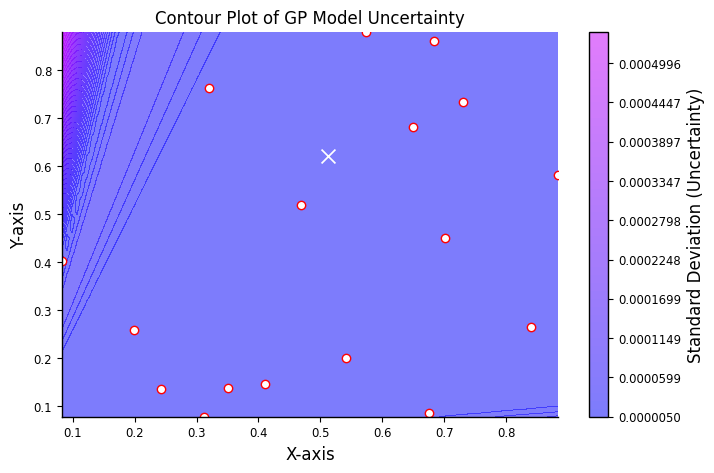

In [29]:
if feature_count == 2:
    # Define the grid over which we will calculate the predictions and uncertainties
    # Find the ranges of the input features
    X_min, X_max = X_train[:, 0].min(), X_train[:, 0].max()
    Y_min, Y_max = X_train[:, 1].min(), X_train[:, 1].max()
    x = np.linspace(X_min, X_max, 100)
    y = np.linspace(Y_min, Y_max, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    XY = np.vstack((X_flat, Y_flat)).T

    # Make the prediction on the grid
    y_pred, sigma = gp.predict(XY, return_std=True)

    # Plotting the uncertainty as a contour plot
    plt.figure()
    contour_levels = np.linspace(sigma.min(), sigma.max(), 50)  
    contour_plot = plt.contourf(X, Y, sigma.reshape(X.shape), levels=contour_levels, cmap=custom_cmap, alpha=0.5)
    plt.colorbar(contour_plot, label='Standard Deviation (Uncertainty)')
    plt.scatter(X_train[:, 0], X_train[:, 1], color='white', edgecolors='red', marker='o', label='Training points')

    plt.scatter(next_sample_reshaped[:, 0], next_sample_reshaped[:, 1], c='w', s=100, marker='x', label='Next sample point')

    plt.title('Contour Plot of GP Model Uncertainty')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    #plt.legend() 
    plt.show()
else:
    None